In [1]:
### SE block 코드 참고 : https://sike6054.github.io/blog/paper/seventh-post/

# [SE-ResNet18]

*KU LeeDongGyu*

## Contents
---

1. Data Preprocessing
```
1) Data Import
2) Data Augmentation
```
2. Support Functions & Almost Original ResNet
```
1) Support Functions
2) Almost orginal ResNet
```
3. ResNet18
```
1) ResNet18
2) ResNet18 Evaluate
```



### Install Packages

### Module

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [3]:
cd /content/drive/My Drive/Colab Notebooks/Paper

/content/drive/My Drive/Colab Notebooks/Paper


In [4]:
from f1score import macro_f1score,weighted_f1score

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from tensorflow import keras as ks
from tensorflow.keras import backend as K 
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input, Concatenate, ZeroPadding2D ,GlobalMaxPooling2D, Reshape , Lambda , Add, Multiply
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, BatchNormalization, AveragePooling2D , ZeroPadding2D, SeparableConv2D
from tensorflow.keras.layers import add
from tensorflow.keras.optimizers import Adam, RMSprop , SGD
from tensorflow.keras.callbacks import EarlyStopping , LearningRateScheduler, ModelCheckpoint, CSVLogger, Callback, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1,l2,l1_l2
from tensorflow.keras.models import Model , load_model , Sequential
from tensorflow.keras.utils import plot_model , to_categorical, get_file
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
os.getcwd()

'/content/drive/My Drive/Colab Notebooks/Paper'

In [7]:
print(tf.__version__)
print(ks.__version__)

2.3.0
2.4.0


In [8]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [9]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7166863746190190782
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9161631300386971073
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 4569558552551518373
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15473775744
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17631793319507350059
physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0"
]


## 1. Data Preprocessing
---

### 1) Data Import

In [10]:
# 바꿔서 살펴 볼 것들
# CALTECH, CIFAR100, FER, MIT
data_name = 'CALTECH'
gan_type = 'No_GAN'
number = '1'
size = 224 # sizes after cropping
super_size = 256 # sizes before cropping 
input_sizes = (size,size,3)
batch_sizes = 128
weight_decay = 5e-4  #resnet18은 3e-4 , se-resnet18은 5e-4
epochs = 75

In [11]:
# 참고 : https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras/52897216#52897216
# setting the seed number for random number generation for reproducibility.

from numpy.random import seed
import random


if number=='1':
    seed_num = 200225
    os.environ['PYTHONHASHSEED']=str(seed_num)
    random.seed(seed_num)
    seed(seed_num)
    tf.random.set_seed(seed_num)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
elif number=='2':
    seed_num = 727
    os.environ['PYTHONHASHSEED']=str(seed_num)
    random.seed(seed_num)
    seed(seed_num)
    tf.random.set_seed(seed_num)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
elif number=='3':
    seed_num = 115
    os.environ['PYTHONHASHSEED']=str(seed_num)
    random.seed(seed_num)
    seed(seed_num)
    tf.random.set_seed(seed_num)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
elif number=='4':
    seed_num = 501
    os.environ['PYTHONHASHSEED']=str(seed_num)
    random.seed(seed_num)
    seed(seed_num)
    tf.random.set_seed(seed_num)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
elif number=='5':
    seed_num = 517
    os.environ['PYTHONHASHSEED']=str(seed_num)
    random.seed(seed_num)
    seed(seed_num)
    tf.random.set_seed(seed_num)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

In [12]:
# data import

if data_name=='FER' :
    x_train =  np.zeros(28698)
    x_valid = np.zeros(3589)
    x_test = np.zeros(3588)
    classes = 7 
    tr_center = [0.50793296, 0.50793296, 0.50793296]
elif data_name=='MIT':
    x_train = np.zeros(12466)
    x_valid = np.zeros(1564)
    x_test = np.zeros(1590)
    classes = 67 
    tr_center = [0.47916578, 0.42029615, 0.36046057]
elif data_name=='CALTECH':
    x_train = np.zeros(24510)
    x_valid = np.zeros(2980)
    x_test = np.zeros(3118)
    classes = 257
    tr_center = [0.51397761, 0.49525248, 0.46555727]
elif data_name=='CIFAR100':
    x_train = np.zeros(39941)
    x_valid = np.zeros(10059)
    x_test = np.zeros(10000)
    classes = 100
    tr_center = [0.53393271, 0.51324147, 0.46450563]

In [13]:
dir = os.path.join(os.getcwd(),data_name,gan_type)

### 2) Data Augmentation

In [14]:
# 참고 : https://jkjung-avt.github.io/keras-image-cropping/

def random_crop(img, random_crop_size):
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3 # img.shape[2] 가 3(rgb)이 아니면 assertion error 발생
    height, width = img.shape[0], img.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return img[y:(y+dy), x:(x+dx), :]


def crop_generator(batches, crop_length):
    """Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator.
    """
    while True:
        batch_x, batch_y = next(batches)
        batch_crops = np.zeros((batch_x.shape[0], crop_length, crop_length, 3))
        for i in range(batch_x.shape[0]):
            batch_crops[i] = random_crop(batch_x[i], (crop_length, crop_length))
        yield (batch_crops, batch_y)

In [15]:
from tensorflow.keras.preprocessing.image import img_to_array,load_img
import glob

# 데이터 전체에 대해 centering 진행함.

def read_cal_image(img_path): 
    x = img_to_array(load_img(img_path)) # x는 채널별 평균값
    y = x.shape[0] * x.shape[1]# y는 데이터별 픽셀 수 (비중)

    x = 1/255. * x # scaling하고, centering값을 뽑아냄.
    x = np.mean(x, axis=(0,1))
    
    return np.hstack([x,y])

def calculate_centered_mean(dataset_path,x_train=x_train):
    num = len(x_train)
    space = np.empty((num,4))
    i=0

    for p in glob.glob(os.path.join(dataset_path,'*/*.*')) :
        space[i] = read_cal_image(p)
        i += 1

    ratio = space[:,3] / np.sum(space[:,3])

    return np.average(space[:,0:3],axis=0,weights=ratio)


# 아래의 함수를 돌려서 나온 결과값을 중심화 값으로 설정.

# train_mean = calculate_centered_mean(os.path.join(dir,'data/train')).reshape((1,1,3))

In [16]:
datagen_tr = ImageDataGenerator(
    rescale=1/255.,
    horizontal_flip=True,
    featurewise_center=True,
    featurewise_std_normalization=False,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=[0.9,1.0],
    fill_mode = 'nearest')
datagen_val = ImageDataGenerator(rescale=1/255.,featurewise_center=True)
datagen_tes = ImageDataGenerator(rescale=1/255.,featurewise_center=True)

# 원래는 이 자리에 fit 매서드를 써야하지만, 그냥 내가 중심화함수를 만들고 적용함. 

# 중심화 설정
datagen_tr.mean = np.array(tr_center, dtype=np.float32).reshape((1,1,3)) # RGB
datagen_val.mean = np.array(tr_center, dtype=np.float32).reshape((1,1,3)) # RGB
datagen_tes.mean = np.array(tr_center, dtype=np.float32).reshape((1,1,3)) # RGB

In [17]:
train_batches = datagen_tr.flow_from_directory(directory=os.path.join(dir,'data/train'),target_size=(super_size,super_size),batch_size=batch_sizes,class_mode='categorical') # fer : 28698 / mit : 12466 / caltech : 24509 / cifar : 39941
train_generator= crop_generator(train_batches, size)
valid_generator = datagen_val.flow_from_directory(directory=os.path.join(dir,'data/valid'),target_size=(size,size),batch_size=batch_sizes,class_mode='categorical') # fer : 3589 / mit : 1564 / caltech : 2980 / cifar : 10059
test_generator = datagen_tes.flow_from_directory(directory=os.path.join(dir,'data/test'),target_size=(size,size),batch_size=batch_sizes,class_mode='categorical') # fer : 3588 / mit : 1590 / caltech : 3118 / cifar : 10000

Found 24509 images belonging to 257 classes.
Found 2980 images belonging to 257 classes.
Found 3118 images belonging to 257 classes.


## 2. Support Functions & Almost Original SE-ResNet
---


### 1) Support Functions

In [18]:
# def lr_schedule(epoch):
#     init_lr = 1e-4
#     k = 0.04
#     lr = init_lr * np.exp(-k*epoch)
#     print('Learning rate: ', lr)
#     return lr

def lr_schedule(epoch):
    lr = 1e-3
    if epoch < 30:
        lr = lr
    elif epoch < 60:
        lr = lr * 0.1
    else :
        lr = lr * 0.01
    print('Learning rate: ', lr)
    return lr

In [19]:
# SE block을 만들고 붙이자.
def SE_block(input_tensor,reduction_ratio):
    ch_input = K.int_shape(input_tensor)[-1]
    ch_reduced = ch_input//reduction_ratio
    
    # Squeeze
    x = GlobalAveragePooling2D()(input_tensor) 
    
    # Excitation
    x = Dense(ch_reduced, activation='relu', kernel_initializer='he_uniform', use_bias=False)(x) 
    x = Dense(ch_input, activation='sigmoid', use_bias=False)(x) 
    
    x = Reshape( (1, 1, ch_input) )(x)
    x = Multiply()([input_tensor, x]) # broadcasting 
    
    return x

In [20]:
# 편의상 아래와 같은 resnet 묶음의 이름을 resnet_layer이라 하자 
def resnet_layer(inputs, weight_decay=weight_decay, num_filters=16, kernel_size=(3,3), strides=(1,1),activation=None):

    conv = Conv2D(num_filters,kernel_size=kernel_size,strides=strides, padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(weight_decay))
    x = inputs
    x = conv(x)
    x = BatchNormalization()(x)
    if activation is not None:
        x = Activation(activation)(x) # conv-bn-activation
    return x

In [21]:
# resnet 코드를 만들기 앞서, 코드가 너무 길어 비효율적이므로 적당한 함수를 만든다.
# block_v1 은 resnet18과 resnet34에 특화된 block이고, block_v2는 resnet50, resnet101, resnet152에 특화된 block이다.
# 이 두개의 block은, 나중에 하나의 모형에서 같이 고려될 것이다.

def block_v1(input_shape, num_filters, reduction_ratio, identi, half=True):
    # identi : resnet의 존재 이유인, 더하게 될 자기자신값이다.
    if half:
        layer1 = resnet_layer(inputs=input_shape, num_filters=num_filters, strides=(2, 2), activation='relu')
        layer2 = resnet_layer(inputs=layer1, num_filters=num_filters, strides=(1, 1), activation=None)
    else:
        layer1 = resnet_layer(inputs=input_shape, num_filters=num_filters, strides=(1, 1), activation='relu')
        layer2 = resnet_layer(inputs=layer1, num_filters=num_filters, strides=(1, 1), activation=None)

    # SE block 추가
    layer2 =  SE_block(layer2, reduction_ratio)
    
    res_2_1 = add([identi, layer2])  # block 1
    output = Activation("relu")(res_2_1)
    return output


def block_v2(input_shape, num_filters, reduction_ratio, identi, half=True):
    # identi : resnet의 존재 이유인, 더하게 될 자기자신값이다.
    if half:
        layer1 = resnet_layer(inputs=input_shape, num_filters=num_filters, strides=(2, 2), kernel_size=(1, 1), activation='relu')
        layer2 = resnet_layer(inputs=layer1, num_filters=num_filters, strides=(1, 1), kernel_size=(3, 3), activation='relu')
        layer3 = resnet_layer(inputs=layer2, num_filters= 4*num_filters, strides=(1, 1), kernel_size=(1, 1), activation=None)
    else:
        layer1 = resnet_layer(inputs=input_shape, num_filters= num_filters, strides=(1, 1), kernel_size=(1, 1), activation='relu')
        layer2 = resnet_layer(inputs=layer1, num_filters= num_filters, strides=(1, 1), kernel_size=(3, 3), activation='relu')
        layer3 = resnet_layer(inputs=layer2, num_filters= 4*num_filters, strides=(1, 1), kernel_size=(1, 1), activation=None)

    # SE block 추가
    layer3 =  SE_block(layer3, reduction_ratio)        

    res_3_1 = add([identi, layer3])  # block 1
    output = Activation("relu")(res_3_1)
    return output

### 2) Almost Orginial SE-ResNet


In [22]:
# 좀더 깔끔하게 작성됨. 앞으로의 resnet모형은 다음의 함수에서 해결한다.
def SE_ResNet(input_shape=(224, 224, 3), classes=1000, num_filters=64, num_blocks=[0,0,0,0], reduction_ratio=16 , version=None, name=None, weight_decay=weight_decay):
    # num_blocks 는 list로 받는 인자. conv3_x ~ conv5_x의 block의 수를 앞에서부터 차례로 넣어주면 된다.
    # num_filters 는 초기의 filters를 의미한다.
    
    if len(num_blocks) != 4 :
        raise NameError("Please input the number of blocks from conv2_x to conv5_x in the 'num_blocks' variable.")

    if version == "v1" : # resnet 18, 34에 해당. (블록이 같음)
        block = block_v1
    elif version == "v2": # resnet 50, 101, 152에 해당. (블록이 같음)
        block = block_v2
    else :
        raise NameError("Please input the string 'v1' or 'v2' in the 'version' variable. ")

    inputs = Input(shape=input_shape)

    # conv1
    layer1 = resnet_layer(inputs=inputs, num_filters=num_filters, strides=(2, 2), kernel_size=(7, 7), activation='relu')
    cum_block = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same', name='pool1/3x3_s2')(layer1)
    
    # cum_block 변수에 하나씩 residual block을 누적시켜보자.

    for stack in range(4):
        if stack == 0 :
            # 우리가 누적시킬 변수, cum_block을 정의하고, 이 변수에 누적시켜가면서 모형을 출력한다.

            # 이 아래 for문은 conv2_x
            # 들어가기 전에, block_v2라면 input과 output의 filter size를 동일하게 해주는 작업을 한다. 덧셈이 가능해야 하므로, 반드시!
            if version == 'v2':
                x = Conv2D(4 * num_filters, kernel_size=(1, 1), strides=(1, 1), padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(weight_decay))(cum_block)
                x = BatchNormalization()(x) # 모든 conv.뒤에는 bn을 적용.
                cum_block = block(input_shape=cum_block, num_filters=num_filters, reduction_ratio=reduction_ratio, identi=x, half=False)

            if version != 'v2':
                  new_num_blocks = num_blocks[stack]
            else :
                  new_num_blocks = num_blocks[stack]-1

            for res_block in range(new_num_blocks):
                cum_block = block(input_shape=cum_block, num_filters=num_filters, reduction_ratio=reduction_ratio, identi=cum_block, half=False)
        else:

            # 이 아래는 conv3_x ~ conv5_x 까지.
            num_filters *= 2
 
            if version == 'v2':
                x = Conv2D(4 * num_filters, kernel_size=(1, 1), strides=(2, 2), padding='valid', kernel_initializer='he_uniform', kernel_regularizer=l2(weight_decay))(cum_block)  # block_v2라면, input에 해당하는 x를 덧셈이 가능하게 맞춰준다.
                x = BatchNormalization()(x) # 모든 conv.뒤에는 bn을 적용.
            else:
                x = Conv2D(num_filters, (1, 1), strides=(2, 2), padding='valid', kernel_initializer='he_uniform', kernel_regularizer=l2(weight_decay))(cum_block)  # identi_input 에 해당 // rxc가 각각 반토막남.
                x = BatchNormalization()(x) # 모든 conv.뒤에는 bn을 적용.
                #즉, 위 x는 결국 이어질 conv 층의 input임.

            for res_block in range(num_blocks[stack]):
                if res_block == 0:
                    cum_block = block(input_shape=cum_block , num_filters = num_filters , reduction_ratio=reduction_ratio, identi=x, half=True) # block 갱신
                else:
                    cum_block = block(input_shape=cum_block , num_filters = num_filters , reduction_ratio=reduction_ratio, identi=cum_block , half=False) # block 갱신

    # 마지막 1층
    y = GlobalAveragePooling2D()(cum_block)
    outputs = Dense(classes, activation='softmax')(y)

    model = Model(inputs=inputs, outputs=outputs, name = name)
    return model


## 3. SE-ResNet18
---

### 1) SE-ResNet18

In [23]:
# SE_ResNet18
model = SE_ResNet(input_shape=input_sizes, classes=classes, reduction_ratio=16,num_blocks=[2,2,2,2],version='v1',name='SE_ResNet18')

In [24]:
model.summary()

Model: "SE_ResNet18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           batch_normalization[0][0]        
________________________________________________________________________________________

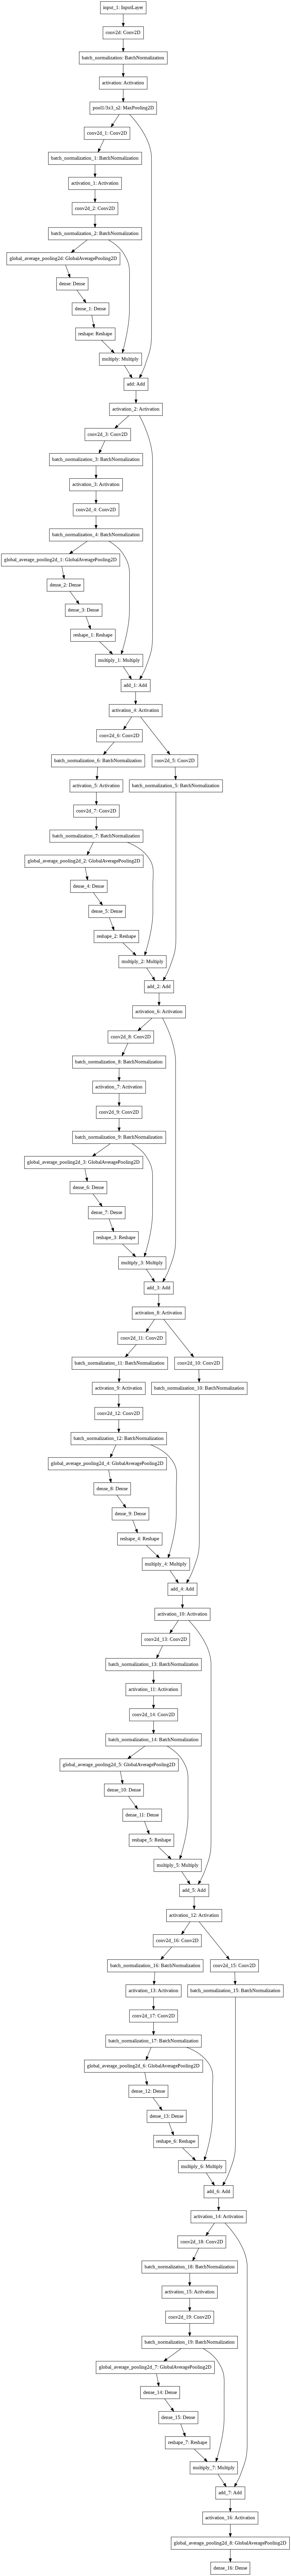

In [25]:
plot_model(model)

In [26]:
# 폴더 생성

os.makedirs(os.path.join(dir,'model_output',number,model.name), exist_ok=True)
os.makedirs(os.path.join(dir,'train_valid_output',number), exist_ok=True)

In [27]:
# AdamW 시작 / AdamWR은 epoch을 500번은 돌려야 될 것 같아 힘듦.
# 참고 : https://github.com/OverLordGoldDragon/keras-adamw

import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/Paper')
import utils
import optimizers_v2
from utils import get_weight_decays, fill_dict_in_order
from utils import reset_seeds, K_eval
from optimizers_v2 import AdamW, NadamW, SGDW

In [28]:
optimizer = AdamW(model=model, use_cosine_annealing=False, total_iterations = len(x_train) // batch_sizes )
#optimizer = Adam()
filepath =  os.path.join(dir,'model_output',number,model.name,'{epoch:03d}.h5')

callbacks_list = [ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_weights_only=False, save_best_only=True, mode='min'),
                  ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_weights_only=False, save_best_only=True, mode='max'),
                  #ReduceLROnPlateau(monitor='val_loss',patience=3,factor=0.1,min_lr=1e-5),
                  LearningRateScheduler(lr_schedule,verbose=1)
                  ]
                  
model.compile(optimizer, loss = 'categorical_crossentropy', metrics=['accuracy',macro_f1score,weighted_f1score])

In [ ]:
######## flow_from_directory
history = model.fit(train_generator, steps_per_epoch=int(len(x_train)/batch_sizes),  validation_data = valid_generator, epochs=epochs , verbose=1 , callbacks = callbacks_list , validation_steps=int(len(x_valid)/batch_sizes))

### 2) SE-ResNet18 Evaluate

In [ ]:
# 1. epoch=maximum
loss , acc, mf1, wf1 = model.evaluate(test_generator,steps=int(len(x_test)/batch_sizes))
print('[Test Loss: %.4f /  Test Accuracy: %.4f / Test Macro f1: %.4f / Test Weighted f1: %.4f]\n' % (loss,acc,mf1,wf1))

In [ ]:
loss=history.history['loss']
val_loss=history.history['val_loss']
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
f1=history.history['macro_f1score']
val_f1=history.history['val_macro_f1score']
epochs=range(1,len(acc)+1)

data = np.array([epochs,loss,val_loss,acc,val_acc,f1,val_f1]).T

In [ ]:
# data save
# epochs, loss, val_loss, acc, val_acc, f1, val_f1

np.savetxt(os.path.join(dir,'train_valid_output',number,model.name+'.txt'),data)

In [ ]:
# data import
data = np.loadtxt(os.path.join(dir,'train_valid_output',number,'SE_ResNet18.txt'))

In [ ]:
epochs=data[:,0]
loss=data[:,1]
val_loss=data[:,2]
acc=data[:,3]
val_acc=data[:,4]

In [ ]:
plt.plot(epochs[1:],acc[1:],'b',label='Training Acc')
plt.plot(epochs[1:],val_acc[1:],'r',label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()
plt.plot(epochs[10:],loss[10:],'b',label='Training Loss')
plt.plot(epochs[10:],val_loss[10:],'r',label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
# 이 아래는 내가 인위적으로 살펴보고 싶은 epoch에 대해서 결과값 출력 / SE_ResNet18

In [ ]:
model=load_model(os.path.join(dir,'model_output',number,'SE_ResNet18','031.h5'),custom_objects={"macro_f1score": macro_f1score,"weighted_f1score":weighted_f1score})

In [ ]:
# 2. epoch=?
loss , acc, mf1, wf1 = model.evaluate(test_generator,steps=int(len(x_test)/batch_sizes))
print('[Test Loss: %.4f /  Test Accuracy: %.4f / Test Macro f1: %.4f / Test Weighted f1: %.4f]\n' % (loss,acc,mf1,wf1))